In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns 
# Spis cech dla train.csv:  
# - building_id - klucz obcy dla ewentualnego mergowania 
# - Meter - zużycie ze względu na { 0 : elektrycznosc , 1 : chłodna woda , 2 : gaz , 3 : gorąca woda } 
# - Timestamp - czas dokonania pomiaru (choć nie jestem pewny) 
# - meter_reading - Target - konsumpcja w kWh
# Dane zostały zebrane w realnych warunkach dlatego możliwe jest występowanie błędów pomiarowych które mają wpływ na model 
# Spis dla building_meta.csv: 
# - site_id 
# - building_id - Klucz obcy dla mergowania z train.csv
# - primary_use - Główna determinanta zużycia w danym budynku ( na jakie czynności pochłaniane jest najwięcej energii) 
# - Square_feet - Powierzchnia budynku 
# - year_built - Rok budowy budynku 
# - floor_count - liczba pięter budynków ( Jest NaN) 
# Spis cech dla weather_train/test: 
# - site_id 
# - Timestamp - Jeśli ta cecha definiuje kiedy został dokonany pomiar to czas jest tutaj przesunięty o rok 
# - air_temperature - temperatura powietrza ( Celsjusze)
# - cloud_coverage - Wskaźnik zakrycia chmurami, oktanowa : 0-8 
# - dew_temperature - temperatura rosy ? 
# - precip_depth_1h - opady atmosferyczne mierzone co godzine 
# - sea_level_pressure - ciśnienie w hPa
# - wind_direction - kierunek wiatru 
# - wind_speed - predkość wiatru w m/s 
# Spis dla test.csv: 
# - row_id - wiersz do podsumowania 
# - building_id - Klucz obcy 
# - meter - target 
# - timestamp - czas 

In [2]:
train_dtypes = {'building_id':'uint16',
               'meter':'uint8',
               'meter_reading':'float32'}
weather_dtypes = {'site_id':'uint8',
                 'air_temperature':'float32',
                 'cloud_coverage':'float32',
                 'dew_temperature':'float32',
                 'precip_depth_1h':'int16',
                 'sea_level_pressure':'float32',
                 'wind_direction':'float32',
                 'wind_speed':'float32'}

df_build_meta = pd.read_csv('./data/building_metadata.csv')
df_test = pd.read_csv('./data/test.csv',parse_dates=['timestamp'])
df_train = pd.read_csv('./data/train.csv',parse_dates=['timestamp'],dtype=train_dtypes)
df_weather_test = pd.read_csv('./data/weather_test.csv',parse_dates=['timestamp'],dtype=weather_dtypes)
df_weather_train = pd.read_csv('./data/weather_train.csv',parse_dates=['timestamp'],dtype=weather_dtypes)

Text(0.5, 1.0, 'Meter Histogram')

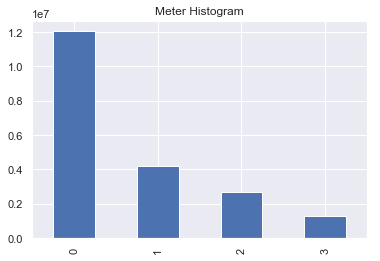

In [6]:
# Plot znormalizowanej kolumny meter, zorientowanie się jak przedstawia się histogram zużycia.
sns.set(style='darkgrid')
df_train['meter'].value_counts().plot(kind='bar')
plt.title("Meter Histogram")

Text(0.5, 1.0, 'Primary use')

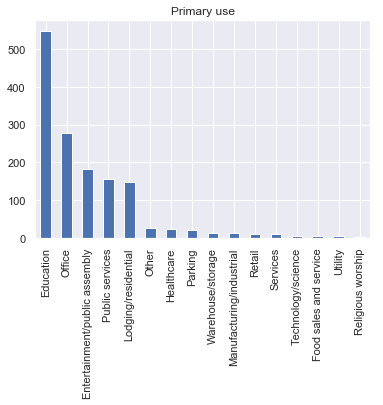

In [7]:
# Plot Primary use 
df_build_meta['primary_use'].value_counts().plot(kind='bar')
plt.title('Primary use')

In [8]:
# Merging Train Data  
train = df_train.merge(df_build_meta,left_on='building_id',right_on='building_id',how='left')
train = train.merge(df_weather_train,on=['site_id','timestamp'],how='left')
train = train.drop(['year_built','floor_count'],axis=1)
train.head(10)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
5,5,0,2016-01-01,0.0,0,Education,8000,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
6,6,0,2016-01-01,0.0,0,Lodging/residential,27926,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
7,7,0,2016-01-01,0.0,0,Education,121074,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
8,8,0,2016-01-01,0.0,0,Education,60809,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
9,9,0,2016-01-01,0.0,0,Office,27000,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0


Text(0.5, 1.0, 'After Target Encoding')

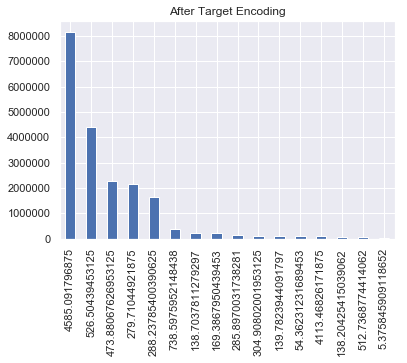

In [9]:
# Applying Target Encoding 
means = train.groupby('primary_use')['meter_reading'].mean() 
train['primary_use'] = train['primary_use'].map(means)
# Plotting the data after target encoding 
train['primary_use'].value_counts().plot(kind='bar')
plt.title("After Target Encoding")

In [10]:
# Percent of available data
available_data = train.count()/len(train)
print(available_data)

building_id           1.000000
meter                 1.000000
timestamp             1.000000
meter_reading         1.000000
site_id               1.000000
primary_use           1.000000
square_feet           1.000000
air_temperature       0.995219
cloud_coverage        0.563449
dew_temperature       0.995047
precip_depth_1_hr     0.814553
sea_level_pressure    0.939075
wind_direction        0.928322
wind_speed            0.992893
dtype: float64


In [11]:
# Filling Nan Values 

def filling_nan(df): 
    ratio = df.count()/len(df)
    cols = ratio[ratio < 1].index
    for col in cols:
        print("Filling Column"+ " " + col)
        df[col] = df[col].fillna(df[col].mean())
    return df 

train_filled = filling_nan(train)
check_if_filled = train_filled.count()/len(train_filled)
print(check_if_filled)

Filling Column air_temperature
Filling Column cloud_coverage
Filling Column dew_temperature
Filling Column precip_depth_1_hr
Filling Column sea_level_pressure
Filling Column wind_direction
Filling Column wind_speed
building_id           1.0
meter                 1.0
timestamp             1.0
meter_reading         1.0
site_id               1.0
primary_use           1.0
square_feet           1.0
air_temperature       1.0
cloud_coverage        1.0
dew_temperature       1.0
precip_depth_1_hr     1.0
sea_level_pressure    1.0
wind_direction        1.0
wind_speed            1.0
dtype: float64


In [12]:
# Dividing timestamp on year,month,day,hour,weekday 
year = train_filled['timestamp'].dt.year.astype(np.uint16)
month = train_filled['timestamp'].dt.month.astype(np.uint8)
day = train_filled['timestamp'].dt.day.astype(np.uint8)
hour = train_filled['timestamp'].dt.hour.astype(np.uint8)
weekend = train_filled['timestamp'].dt.weekday.astype(np.uint8)

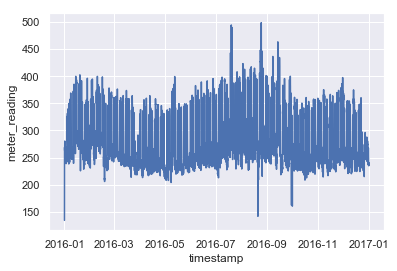